In [1]:
counts_file="results/tables/counts.tsv"
summary_file="results/tables/counts.tsv.summary"
multiqc_file="results/multiqc/multiqc_general_stats.txt"
rulegraph_file="results/rulegraph.png"
SRR_ids = ["SRR935090","SRR935091","SRR935092"]

## Overview

This document contains supplementary tables and plots from an analysis workflow
run on data from an RNA-Seq experiment on _Staphylococcus aureus_ [@osmundson2013rna].

## Supplementary tables and figures

In [2]:
import pandas as pd
import matplotlib_inline
import altair as alt
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
#| label: "fig-barplot"
#| fig-cap: "Barplot of assigned reads per sample"
#| fig-cap-location: "bottom"
multiqc = pd.read_csv(multiqc_file, sep="\t", index_col=0)
multiqc.rename(columns = lambda x: x.replace("FastQC_mqc-generalstats-fastqc-", ""), inplace=True)
multiqc.rename(columns={'percent_duplicates': '%duplicates', 'percent_gc': '%GC', 'avg_sequence_length': 
                        'mean(read length)', 'percent_fails': '%failed', 'total_sequences': 'total seqs'}, inplace=True)
multiqc_plot_data = pd.melt(multiqc.drop("total seqs", axis=1).reset_index(), id_vars=["Sample"], var_name="QC stat", value_name="value")
counts_summary = pd.read_csv(summary_file, sep="\t", index_col=0)
counts_summary.rename(columns = lambda x: x.split("/")[-1].replace(".sorted.bam",""), inplace=True)
summary_plot_data = counts_summary.loc[counts_summary.sum(axis=1)>0]
summary_plot_data = pd.melt(summary_plot_data.reset_index(), id_vars=["Status"], var_name="Sample", value_name="counts")

chart1 = alt.Chart(summary_plot_data, title="Read assignment summary").mark_bar().encode(
    x="Sample", y="counts", color="Status",
    tooltip=["Sample","Status","counts"]
).properties(width=100, height=300)

chart2 = alt.Chart(multiqc_plot_data).mark_bar().encode(
    y="value", x="Sample", column="QC stat",
    tooltip=["Sample","value"]
).properties(width=75, height=300)

alt.hconcat(chart1, chart2).resolve_scale(color="independent")

alt.HConcatChart(...)

In [4]:
#| label: tbl-multiqc
#| tbl-cap: "QC table"
#| tbl-cap-location: "top"
round(multiqc)

,%duplicates,%GC,mean(read length),%failed,total seqs
Sample,,,,,
SRR935090,23.0,38.0,51.0,9.0,25000.0
SRR935091,38.0,39.0,51.0,9.0,25000.0
SRR935092,9.0,36.0,51.0,9.0,25000.0


In [5]:
#| label: fig-heatmap
#| fig-cap: "Heatmap of gene expression"
#| fig-cap-location: "bottom"

counts = pd.read_csv(counts_file, sep="\t", header=0, comment="#", index_col=0)
counts.rename(columns = lambda x: x.split("/")[-1].replace(".sorted.bam",""), inplace=True)
count_data = counts.loc[:, SRR_ids]
# Filter to genes with std/mean > 1.2 and with a max of at least 5
heatmap_data = count_data.loc[(count_data.std(axis=1).div(count_data.mean(axis=1))>1.2)&(count_data.max(axis=1)>5)]
heatmap_data = pd.melt(heatmap_data.reset_index(), id_vars=["Geneid"], var_name="Sample", value_name="counts")

alt.Chart(heatmap_data, title="Heatmap of gene expression").mark_rect().encode(
    x="Sample", y="Geneid", color="counts",
    tooltip=["Sample","Geneid","counts"]
).properties(width=100, height=800)

alt.Chart(...)

## Reproducibility

The code for reproducing this analysis is available in this [GitHub repo](https://github.com/NBISweden/workshop-reproducible-research/tree/main/jupyter).
The repo contains:

* A Snakemake workflow for running all analysis steps
* A Conda environment file for installing all needed dependencies
* A Docker file for running the analysis in a well-defined and isolated system

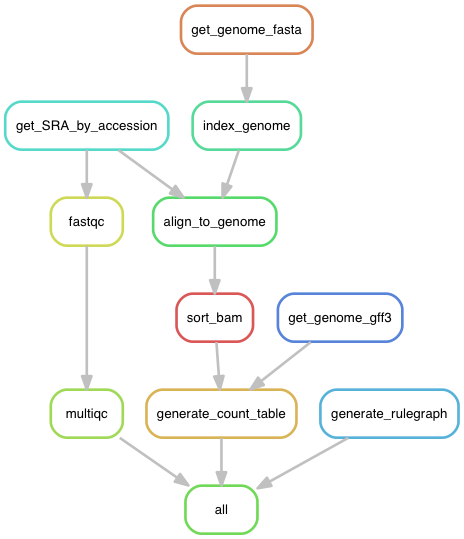

In [6]:
from IPython.display import Image
Image(rulegraph_file)